In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging
from sklearn.naive_bayes import MultinomialNB
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
X_train = pd.read_csv('../data/interim/X-train.csv', usecols = ['question_text'], squeeze=True)
y_train = pd.read_csv('../data/interim/y-train.csv', usecols = ['target'], squeeze=True)
X_test = pd.read_csv('../data/interim/X-test.csv', usecols = ['question_text'], squeeze=True)
y_test = pd.read_csv('../data/interim/y-test.csv', usecols = ['target'], squeeze=True)

In [3]:
X_train.head()

0                   Can I get pregnant by dry humping?
1    Can I divade project in different git submodul...
2                 How can I donate bone marrow in UAE?
3     What are the best books about negative thinking?
4             Why does Texas have high property taxes?
Name: question_text, dtype: object

In [4]:
X_train.shape

(195918,)

In [5]:
X_test.shape

(65306,)

In [6]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

Let's check ratio of '1's tp '0's. 

In [7]:
np.mean(y_test)

0.06186261599240499

In [8]:
def calculate_accuracy(true_y, predicted_y):
    print('Accuracy: ', np.mean(predicted_y==true_y))

In [9]:
def plot_confusion_matrix(true_y, predicted_y):
    df = pd.DataFrame(data = {'y_Actual': true_y,
                              'y_Predicted': predicted_y
                             }, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                                   rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()

In [20]:
def plot_roc(model, X_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Accuracy:  0.9407252013597526


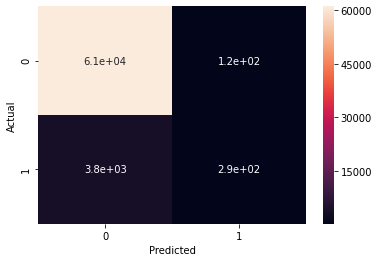

In [11]:
# Logistic regression
log_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log')),
])
log_clf.fit(X_train, y_train)

log_predicted = log_clf.predict(X_test)
calculate_accuracy(y_test,log_predicted)
plot_confusion_matrix(y_test,log_predicted)


Accuracy:  0.9390408232015435


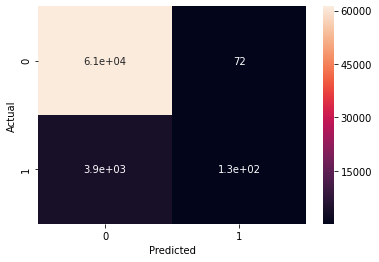

In [12]:
# SVM
svm_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge')),
])
svm_clf.fit(X_train, y_train)

svm_predicted = svm_clf.predict(X_test)
calculate_accuracy(y_test, svm_predicted)
plot_confusion_matrix(y_test, svm_predicted)

Accuracy:  0.9386733225124797


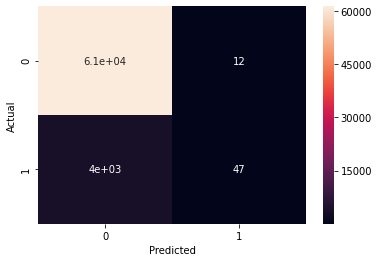

In [13]:
# Naive Bayes
naive_bayes_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

naive_bayes_clf.fit(X_train, y_train)

naive_bayes_predicted = naive_bayes_clf.predict(X_test)
calculate_accuracy(y_test, naive_bayes_predicted)
plot_confusion_matrix(y_test, naive_bayes_predicted)

In [14]:
def calc_precision_recall(model, X_test, y_test):
    y_scores = model.predict_proba(X_test)[:, 1]
    p, r, thresholds = precision_recall_curve(y_test, y_scores)
    l = len(thresholds)
    p_r_th_df = pd.DataFrame({'Precision': p[0:l], 
                              'Recall':r[0:l], 
                              'Threshold':thresholds[0:l]})
    return p_r_th_df

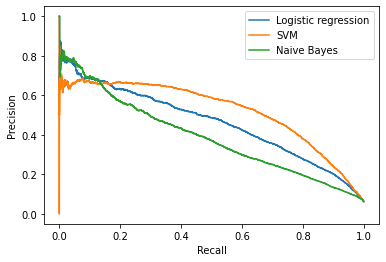

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

y_score = log_clf.predict_proba(X_test)[:, 1]
prec1, recall1, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=log_clf.classes_[1])

y_score = svm_clf.decision_function(X_test)
prec2, recall2, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=svm_clf.classes_[1])

y_score = naive_bayes_clf.predict_proba(X_test)[:, 1]
prec3, recall3, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=naive_bayes_clf.classes_[1])

line1, = plt.plot(recall1, prec1, label='Logistic regression')
line2, = plt.plot(recall2, prec2, label='SVM')
line3, = plt.plot(recall3, prec3, label='Naive Bayes')
plt.legend(handles=[line1, line2, line3])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [16]:
from sklearn.base import BaseEstimator
class DummyClf(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [17]:
from sklearn.feature_extraction import stop_words
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction import text 

wnl = WordNetLemmatizer()
stop_words_lemmatized = [wnl.lemmatize(s) for s in list(stop_words.ENGLISH_STOP_WORDS)]
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words_lemmatized)

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DummyClf()),
])

parameters = [
    {
        'vect__tokenizer': (LemmaTokenizer(),),
        'vect__stop_words': (stop_words,),
        'vect__lowercase': (True,),
        'clf': [SGDClassifier()], # SVM if hinge loss / logreg if log loss
        'clf__max_iter': [100, 200],
        'clf__penalty': ('l1','l2','elasticnet'),
        'clf__alpha': (1e-4, 1e-5, 1e-6),
        'clf__tol': [1e-4],
        'clf__loss': ['hinge', 'log'],
    },
    {
        'vect__tokenizer': (LemmaTokenizer(),),
        'vect__stop_words': (stop_words,),
        'vect__lowercase': (True,),
        'clf': [MultinomialNB()],
        'clf__alpha': (1e-4, 1e-5, 1e-6),
    },
]

gscv = GridSearchCV(pipeline, parameters, cv=5, scoring='average_precision')

In [18]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
t0 = time()
gscv.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % gscv.best_score_)
print("Best parameters set:")
best_parameters = gscv.best_estimator_.get_params()
print(best_parameters['vect'])
print(best_parameters['tfidf'])
print(best_parameters['clf'])

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
done in 5664.275s

Best score: 0.538
Best parameters set:
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
       

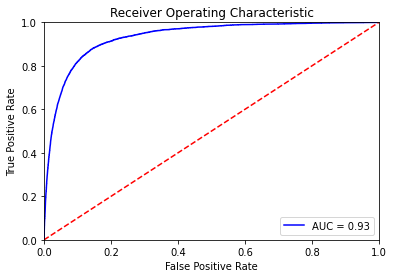

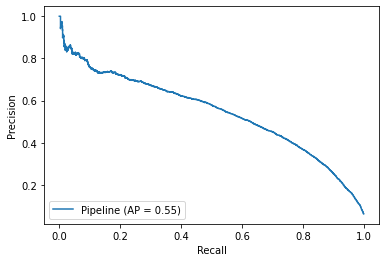

In [21]:
best_model  = gscv.best_estimator_
best_model.fit(X_train, y_train)

plot_roc(best_model, X_test, y_test)

plot_precision_recall_curve(best_model, X_test, y_test)
plt.show()

y_scores = best_model.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)
l = len(thresholds)
p_r_th_df = pd.DataFrame({'Precision': p[0:l], 'Recall':r[0:l], 'Threshold':thresholds[0:l]})


In [22]:
coefs = best_model.named_steps['clf'].coef_[0]

pipe = Pipeline([('vect', gscv.best_estimator_['vect']),
                 ('tfidf', gscv.best_estimator_['tfidf'])]).fit(X_train)

features = pipe['vect'].get_feature_names()

dfx = pd.DataFrame({'features':features, 'coef':coefs})

print('Number of features:', dfx.shape[0])

Number of features: 78786


In [23]:
dfx.sort_values(by=['coef'], inplace=True)

In [24]:
dfx.head(20)

,features,coef
6253,?,-13.980140
23499,difference,-5.383977
45593,meaning,-4.158137
37651,inhabit,-3.979196
65996,song,-3.474914
70064,text,-3.444739
59617,regret,-3.408236
8627,amazon,-3.396875
55822,potential,-3.288171
18809,comfortable,-3.283136


In [25]:
dfx.tail(20)

,features,coef
37139,incest,5.854835
71982,trump,5.866687
15354,butthole,5.879106
48357,muslim,6.002297
64293,shithole,6.011851
58664,rape,6.068087
31394,gay,6.084228
30712,fuck,6.102233
57663,pussy,6.137296
16339,castrating,6.137741
